In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal
from scipy import special

In [2]:
path_eprofile_alc = '/home/bia/Data/E_PROFILE_ALC/L2/L2_0-756-2-ERISWIL_A20250101.nc'
path_testl2 = '/home/bia/euliaa_postproc/data/L2Test_NC_for_Aprofiles.nc'
ds = xr.open_dataset(path_testl2)

In [ ]:
x = np.log(ds.attenuated_backscatter_0)
xf = xr.zeros_like(x)*np.nan
y = xr.zeros_like(x)*np.nan
smooth = True

K = 3 # degree of polynomial
F = 5 # filter window # in RALMO: int(dz/ds.vertical_resolution), dz = 15 m, but doesn't make sense here
# K = 0
# F = 1
if F%2==0:
    F+=1
xf = signal.savgol_filter(x,F,K,deriv = 0)
y = signal.savgol_filter(xf,F,K,deriv = 1)

xf_r = signal.savgol_filter(x[:,::-1],F,K,deriv=0)
y_r = signal.savgol_filter(xf_r,F,K,deriv = 1)
# cloud_base = y[3:]-y[2:-1))<0) & ((y(1:end-2)-y(2:end-1))<0) & y(2:end-1)>1.5)+1;
# else:
#     xf = x
#     xff =

/home/bia/acbr/.venv/lib/python3.10/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [132]:
cloud_base = xr.where((y[:,2:]-y[:,1:-1]<0) & (y[:,:-2]-y[:,1:-1]<0) & (y[:,1:-1]>.3),1,np.nan)

# y_r = y[:,::-1]
cloud_top = xr.where((y_r[:,2:]-y_r[:,1:-1]<0) & (y_r[:,:-2]-y_r[:,1:-1]<0) & (y_r[:,1:-1]>.3),1,np.nan)

# cloud_base_pixel = cloud_base*(ds.altitude[1:-1].broadcast_like(cloud_base))

In [133]:
cloud_base_pixel = ds.altitude.values[1:-1]*cloud_base
cloud_top_pixel = ds.altitude.values[1:-1][::-1]*cloud_top
# plt.colorbar()

In [134]:
time_array = np.repeat(ds.time.values.reshape(-1,1),809)

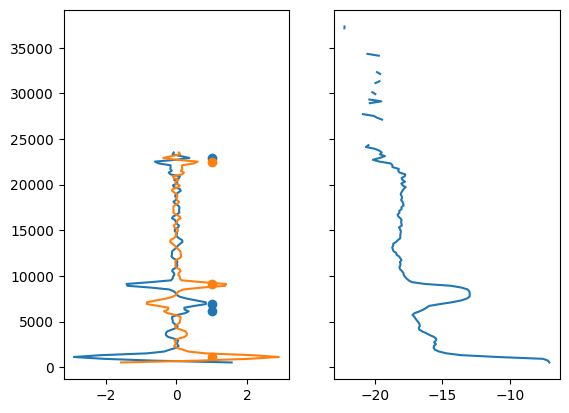

In [135]:
fig,axs = plt.subplots(1,2,sharey=True)
axs[0].plot(y[110],ds.altitude)
axs[0].plot(y_r[110],ds.altitude[::-1])

axs[0].scatter(cloud_base[110],ds.altitude[1:-1])
axs[0].scatter(cloud_top[110],ds.altitude[1:-1][::-1])
axs[1].plot(x[110],ds.altitude)

(0.0, 40000.0)

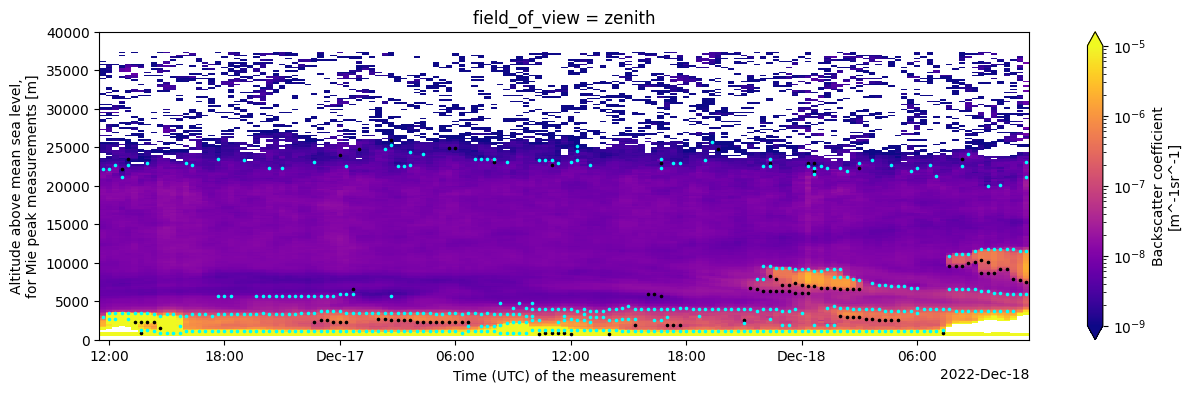

In [136]:
fig = plt.figure(figsize = (15,4))
ds.attenuated_backscatter_0.plot(x='time',vmin=1e-9,vmax=1e-5,norm=colors.LogNorm(),cmap='plasma')
plt.scatter(time_array, cloud_base_pixel,s=10,color='k',marker='.')
plt.scatter(time_array, cloud_top_pixel,s=10,color='cyan',marker='.')
plt.ylim(0,40000)